In [1]:
from copy import deepcopy
import os
import random
import sys

In [2]:
from matplotlib import cm
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.mplot3d.axes3d import Axes3D
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import toml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo

In [3]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from endure.data.io import Reader
from endure.lcm.util import LCMEvalUtil
from endure.lcm.model.builder import LearnedCostModelBuilder
import endure.lcm.data.generator as Gen
from endure.ltune.data.generator import LTuneGenerator
from endure.lsm.types import Policy, LSMDesign, System
from endure.lsm.cost import EndureCost

In [4]:
model_path = '/data/models/lcm/qcost-10-19-v0/'
config = Reader.read_config(os.path.join(model_path, 'endure.toml'))
lsm_design = config['lsm']['design']

In [5]:
config['job']['LCMTrain']

{'max_epochs': 100,
 'save_dir': 'models/lcm/qcost-10-19-v0',
 'use_gpu_if_avail': True,
 'loss_fn': 'MSE',
 'optimizer': 'Adam',
 'lr_scheduler': 'CosineAnnealing',
 'no_checkpoint': False,
 'train': {'dir': 'train-data/qcost-t30',
  'format': 'parquet',
  'batch_size': 4096,
  'shuffle': True,
  'num_workers': 12,
  'drop_last': True},
 'test': {'dir': 'test-data/qcost-t30',
  'format': 'parquet',
  'batch_size': 65536,
  'shuffle': False,
  'num_workers': 4,
  'drop_last': True}}

In [6]:
lsm_design

'QLSM'

In [7]:
if lsm_design in ['Level', 'Tier']:
    gen = Gen.ClassicGenerator(config)
elif lsm_design == 'KLSM':
    gen = Gen.KHybridGenerator(config)
elif lsm_design in ['QLSM', 'QLSMIntegerVars']:
    gen = Gen.QCostGenerator(config)
else:
    gen = Gen.ClassicGenerator(config)

# Loss Graph

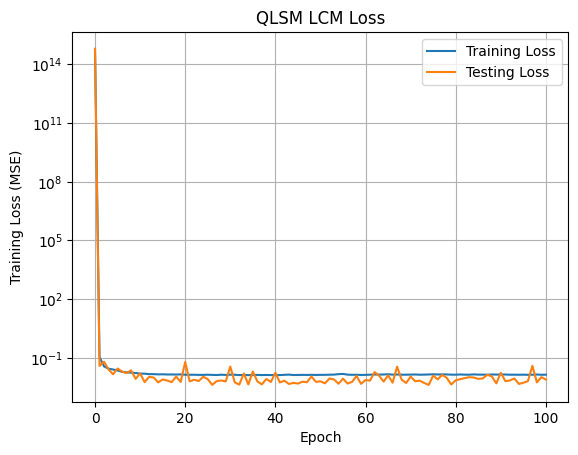

In [8]:
losses = pd.read_csv(os.path.join(model_path, 'losses.csv'))
losses = losses.loc[:100]
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Training Loss ({config["job"]["LCMTrain"]["loss_fn"]})')
ax.set_yscale('log')
ax.grid()
ax.set_title(f'{lsm_design} LCM Loss')
_ = ax.legend()

In [9]:
losses.idxmin()

epoch          0
train_loss    34
test_loss     74
dtype: int64

# Building

## Model

In [10]:
model_name = os.path.join(model_path, 'best.model')
# model_name = os.path.join(model_path, 'checkpoints/epoch_02.checkpoint')
# last_checkpoint = os.listdir(os.path.join(model_path, 'checkpoints'))[-1]
# model_name = os.path.join(model_path, 'checkpoints', last_checkpoint)

builder = LearnedCostModelBuilder(config)
model = builder.build_model()
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
load_status = model.load_state_dict(model_params)
model.eval()
load_status

<All keys matched successfully>

In [11]:
torchinfo.summary(model, (1, 70), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
QModel                                   [1, 4]                    --
├─Linear: 1-1                            [1, 8]                    248
├─Linear: 1-2                            [1, 8]                    248
├─BatchNorm1d: 1-3                       [1, 26]                   52
├─Linear: 1-4                            [1, 32]                   864
├─ReLU: 1-5                              [1, 32]                   --
├─Dropout: 1-6                           [1, 32]                   --
├─Sequential: 1-7                        [1, 32]                   --
│    └─Linear: 2-1                       [1, 32]                   1,056
│    └─ReLU: 2-2                         [1, 32]                   --
│    └─Linear: 2-3                       [1, 32]                   1,056
│    └─ReLU: 2-4                         [1, 32]                   --
│    └─Linear: 2-5                       [1, 32]                   1,056
│  

# Utils

In [12]:
eval_util = LCMEvalUtil(config, model, gen)

In [13]:
wl = (z0, z1, q, w) = gen._sample_workload(4)
system = gen._sample_system()
design = gen._sample_design(system)
print(design)
print(system)
eval_util.cf.calc_cost(design, system, z0, z1, q, w), eval_util.eval_lcm(design, system, z0, z1, q, w)

LSMDesign(h=1.558, T=22, policy=<Policy.QFixed: 3>, Q=8, Y=1.0, Z=1.0, K=[])
System(E=8192, s=6.382696740170611e-08, B=4.0, N=102484345, H=18.249230349525114, phi=1.0)


(4.660323007273019, 4.480527877807617)

In [14]:
eval_util.gen_random_sample()

({'z0': 0.014,
  'z1': 0.382,
  'q': 0.365,
  'w': 0.239,
  'B': 64.0,
  's': 1.5407334326052278e-08,
  'E': 1024,
  'H': 16.422144914349047,
  'N': 938571508,
  'h': 13.108,
  'T': 18,
  'Q': 7,
  'cost_lcm': 5.484709739685059,
  'cost_acm': 5.563684874697822},
 LSMDesign(h=13.108, T=18, policy=<Policy.QFixed: 3>, Q=7, Y=1.0, Z=1.0, K=[]),
 System(E=1024, s=1.5407334326052278e-08, B=64.0, N=938571508, H=16.422144914349047, phi=1.0))

## LCM Evaluation

In [15]:
num_samples = 10000
table = []
bad = []
for _ in tqdm(range(num_samples)):
    row, design, system = eval_util.gen_random_sample()
    norm_delta = (row['cost_acm'] - row['cost_lcm']) / row['cost_acm']
    if (norm_delta < -1) or (norm_delta > 1):
        print(norm_delta, system, design, row['z0'], row['z1'], row['q'], row['w'])
        bad.append((norm_delta, row['z0'], row['z1'], row['q'], row['w'], design, system))
    table.append(deepcopy(row))
table = pd.DataFrame(table)
df = table

  0%|          | 0/10000 [00:00<?, ?it/s]

-1.3495825693399297 System(E=8192, s=5.34004709904228e-08, B=4.0, N=221536954, H=6.949233956650913, phi=1.0) LSMDesign(h=3.845, T=26, policy=<Policy.QFixed: 3>, Q=1, Y=1.0, Z=1.0, K=[]) 0.885 0.08599999999999997 0.0040000000000000036 0.025000000000000022


In [16]:
df['delta'] = (df['cost_acm'] - df['cost_lcm'])
df['norm_delta'] = df['delta'] / df['cost_acm']
df.sort_values(by='norm_delta', ascending=False)

,z0,z1,q,w,B,s,E,H,N,h,T,Q,cost_lcm,cost_acm,delta,norm_delta
4346,0.838,0.008,0.003,0.151,32.0,9.938353e-09,4096,12.067121,160402214,5.684,5,2,0.091160,0.293841,0.202681,0.689764
1157,0.830,0.128,0.012,0.030,32.0,1.156438e-08,1024,10.043152,405510903,7.495,15,1,0.093816,0.217218,0.123402,0.568101
6337,0.020,0.055,0.003,0.922,64.0,3.972116e-08,1024,10.129572,408446726,3.784,30,13,0.142186,0.295392,0.153207,0.518654
7352,0.716,0.093,0.001,0.190,16.0,2.572540e-08,2048,14.983841,691910566,8.232,5,2,0.142001,0.281196,0.139195,0.495011
1511,0.115,0.287,0.007,0.591,128.0,5.068142e-08,1024,18.048105,458903011,4.239,8,1,0.252413,0.408874,0.156461,0.382662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,0.506,0.455,0.028,0.011,8.0,8.832931e-08,8192,12.249089,222234137,4.189,23,1,0.995953,0.739956,-0.255997,-0.345963
8614,0.700,0.000,0.001,0.299,8.0,6.472418e-08,4096,11.683450,660541347,7.503,30,18,0.867185,0.637968,-0.229218,-0.359294
2562,0.436,0.010,0.005,0.549,64.0,1.651279e-08,1024,8.892155,356313991,8.540,19,11,0.450152,0.320221,-0.129930,-0.405752
2722,0.475,0.087,0.000,0.438,32.0,6.011731e-08,4096,12.375336,379482024,11.437,12,10,0.315625,0.212867,-0.102758,-0.482731


In [17]:
cost, z0, z1, q, w, design, system = bad[0]
cost, z0, z1, q, w, design, system

(-1.3495825693399297,
 0.885,
 0.08599999999999997,
 0.0040000000000000036,
 0.025000000000000022,
 LSMDesign(h=3.845, T=26, policy=<Policy.QFixed: 3>, Q=1, Y=1.0, Z=1.0, K=[]),
 System(E=8192, s=5.34004709904228e-08, B=4.0, N=221536954, H=6.949233956650913, phi=1.0))

In [18]:
acm = eval_util.cf.calc_cost(design, system, z0, z1, q, w)
lcm = eval_util.eval_lcm(design, system, z0, z1, q, w)
acm, lcm, (acm - lcm) / acm

(0.6663394124211586, 1.5656194686889648, -1.3495825693399297)

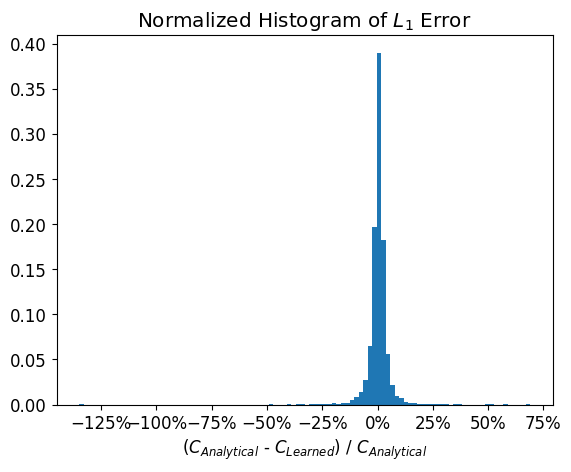

In [19]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
data = df['norm_delta'].values
ax.hist(data, bins=100, weights=np.ones_like(data)/len(data))
ax.set_xlabel('($C_{Analytical}$ - $C_{Learned}$) / $C_{Analytical}$')
ax.set_title('Normalized Histogram of $L_1$ Error')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))

In [20]:
cutoff = 0.05
data = df[(df.norm_delta < cutoff) & (df.norm_delta > -cutoff)]
print(f'Percentange within {cutoff:.0%} delta: {len(data) / len(df):.3%}')

Percentange within 5% delta: 88.870%


In [21]:
data = df[(df.norm_delta < 0.05) & (df.norm_delta > -0.05)]
data.sort_values(by='norm_delta')

,z0,z1,q,w,B,s,E,H,N,h,T,Q,cost_lcm,cost_acm,delta,norm_delta
9354,0.531,0.216,0.063,0.190,32.0,5.270590e-08,4096,5.865702,862118821,4.835,5,4,2.224822,2.119175,-0.105647,-0.049853
4455,0.294,0.002,0.353,0.351,8.0,3.605031e-09,4096,7.304510,886743646,2.133,26,3,3.703049,3.527885,-0.175164,-0.049651
8381,0.061,0.394,0.175,0.370,64.0,6.017039e-08,1024,15.685518,748321513,1.648,22,2,1.344393,1.280988,-0.063405,-0.049497
8063,0.101,0.159,0.164,0.576,32.0,2.139019e-08,4096,19.607058,264392544,11.920,11,2,1.397057,1.331211,-0.065846,-0.049463
4199,0.338,0.220,0.029,0.413,64.0,8.479944e-08,2048,5.563035,329466005,3.415,14,13,2.844745,2.710790,-0.133955,-0.049416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6699,0.354,0.567,0.050,0.029,32.0,6.136287e-08,1024,13.032617,251146249,6.290,6,1,0.743746,0.782749,0.039004,0.049829
8956,0.440,0.199,0.334,0.027,16.0,9.382642e-08,8192,9.218781,714929102,4.272,16,1,2.507334,2.638856,0.131522,0.049840
2651,0.345,0.004,0.003,0.648,4.0,5.495216e-08,8192,12.280976,224837525,10.205,3,2,2.388685,2.513990,0.125305,0.049843
7350,0.248,0.219,0.387,0.146,32.0,9.390238e-08,4096,5.052696,827435420,4.341,11,2,3.952795,4.160497,0.207703,0.049923


In [22]:
data = df[(df.norm_delta > 0.05) | (df.norm_delta < -0.05)]
data.sort_values(by='norm_delta')

,z0,z1,q,w,B,s,E,H,N,h,T,Q,cost_lcm,cost_acm,delta,norm_delta
2154,0.885,0.086,0.004,0.025,4.0,5.340047e-08,8192,6.949234,221536954,3.845,26,1,1.565619,0.666339,-0.899280,-1.349583
2722,0.475,0.087,0.000,0.438,32.0,6.011731e-08,4096,12.375336,379482024,11.437,12,10,0.315625,0.212867,-0.102758,-0.482731
2562,0.436,0.010,0.005,0.549,64.0,1.651279e-08,1024,8.892155,356313991,8.540,19,11,0.450152,0.320221,-0.129930,-0.405752
8614,0.700,0.000,0.001,0.299,8.0,6.472418e-08,4096,11.683450,660541347,7.503,30,18,0.867185,0.637968,-0.229218,-0.359294
585,0.506,0.455,0.028,0.011,8.0,8.832931e-08,8192,12.249089,222234137,4.189,23,1,0.995953,0.739956,-0.255997,-0.345963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,0.115,0.287,0.007,0.591,128.0,5.068142e-08,1024,18.048105,458903011,4.239,8,1,0.252413,0.408874,0.156461,0.382662
7352,0.716,0.093,0.001,0.190,16.0,2.572540e-08,2048,14.983841,691910566,8.232,5,2,0.142001,0.281196,0.139195,0.495011
6337,0.020,0.055,0.003,0.922,64.0,3.972116e-08,1024,10.129572,408446726,3.784,30,13,0.142186,0.295392,0.153207,0.518654
1157,0.830,0.128,0.012,0.030,32.0,1.156438e-08,1024,10.043152,405510903,7.495,15,1,0.093816,0.217218,0.123402,0.568101


In [23]:
def plot_workload_trend(df, trend='stune_T'):
    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax)
    ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
    ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

    ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
    ax.set_ylabel('Range-Reads (q)', labelpad=10)
    ax.set_zlabel('Writes (w)', labelpad=10)

    sc = ax.scatter(df['z0'] + df['z1'], df['q'], df['w'], c=df[trend], cmap='viridis')
    cbar = plt.colorbar(sc)
    cbar.set_label(trend)
    
    return fig, ax, sc, cbar

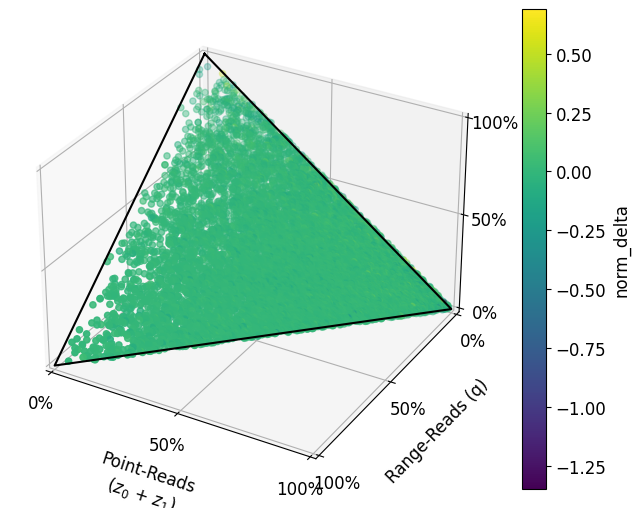

In [24]:
fig, ax, sc, cbar = plot_workload_trend(df, 'norm_delta')

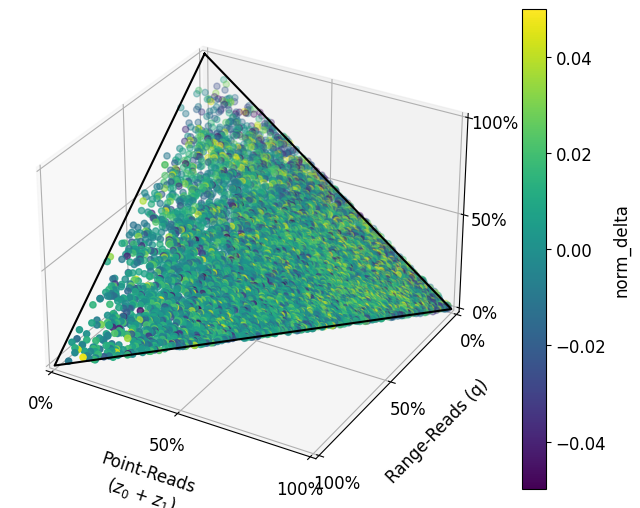

In [32]:
fig, ax, sc, cbar = plot_workload_trend(df[(df.norm_delta < 0.05) & (df.norm_delta > -0.05)], 'norm_delta')

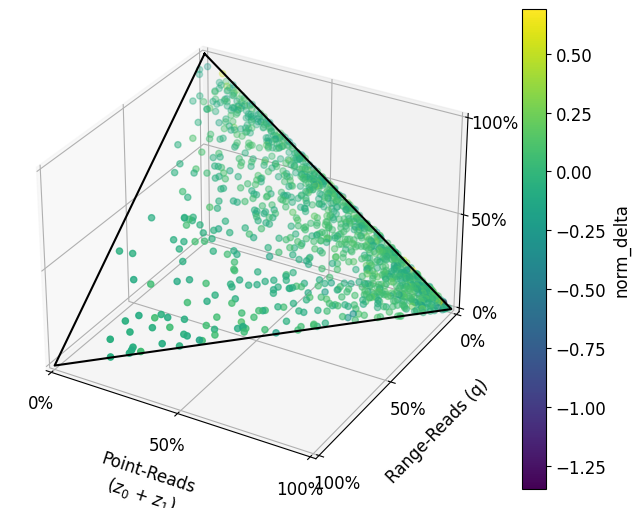

In [33]:
fig, ax, sc, cbar = plot_workload_trend(df[(df.norm_delta > 0.05) | (df.norm_delta < -0.05)], 'norm_delta')

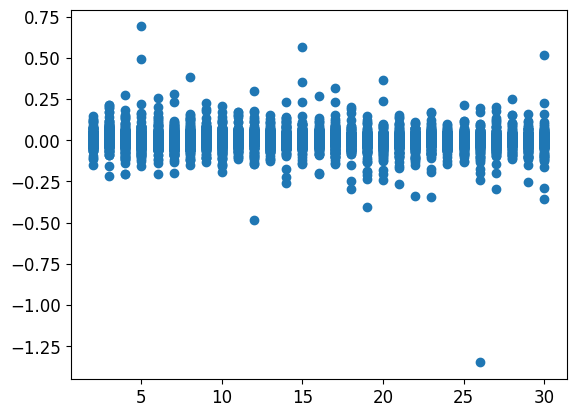

In [27]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
ax.scatter(df['T'], df.norm_delta)
None